In [1]:
from NN import *
from LTL import *
from Utility_funcs import *

from csrl.mdp import GridMDP
from csrl.oa import OmegaAutomaton
from csrl import ControlSynthesis
import numpy as np
import os

from matplotlib import pyplot as plt
import time 

Number of Omega-automaton states (including the trap state): 6


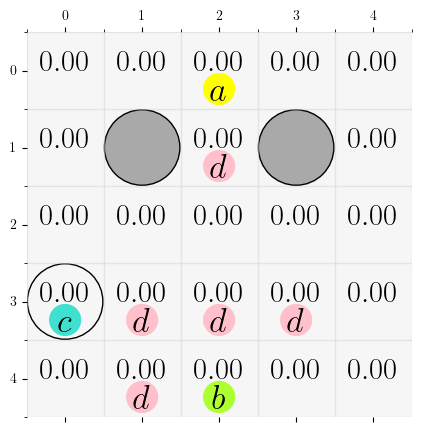

In [2]:
ltl = ("(G !d) & ((!c) U b) & ((!b) U a) & (F G c)")

# Translate the LTL formula to an LDBA
oa = OmegaAutomaton(ltl)
print('Number of Omega-automaton states (including the trap state):',oa.shape[1])

# MDP Description
shape = (5,5)
# E: Empty, T: Trap, B: Obstacle
structure = np.array([
['E',  'E',  'E',  'E',  'E'],
['E',  'B',  'E',  'B',  'E'],
['E',  'E',  'E',  'E',  'E'],
['T',  'E',  'E',  'E',  'E'],
['E',  'E',  'E',  'E',  'E']
])

# Labels of the states
label = np.array([
[(),    (),    ('a',),    (),    ()],
[(),    (),    ('d',),(),    ()],
[(),    (),    (),    (),    ()],
[('c',),('d',),    ('d',),('d',),()],
[(),    ('d',),    ('b',),(),    ()]
],dtype=object)
# Colors of the labels 
lcmap={
    ('a',):'yellow',
    ('b',):'greenyellow',
    ('c',):'turquoise',
    ('d',):'pink'
}

p = 1
grid_mdp = GridMDP(shape=shape,structure=structure,label=label,lcmap=lcmap, p=p, figsize=5)  # Use figsize=4 for smaller figures
grid_mdp.plot(save="env.pdf")

# Construct the product MDP
csrl = ControlSynthesis(grid_mdp,oa)
max_rew = round(csrl.reward.max(), 3)

s_vectors = state_vectors(csrl)
enc = list(np.unique(grid_mdp.label))
enc.pop(enc.index(()))
ch_states = channeled(csrl, enc)
total_number_of_states = csrl.mdp.shape[0]*csrl.mdp.shape[1]*csrl.oa.shape[1]

In [3]:
t = "[] ~d /\ (~c % b) /\ (~b % a) /\ (<> [] c)"

LTL_formula = parser.parse(t)
predicates=get_predicates(grid_mdp)
print(predicates)

{'a': [2], 'b': [22], 'c': [15], 'd': [7, 16, 17, 18, 21]}


In [4]:
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
N, W, Q, P, visited = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
# model.summary()

In [5]:
# model.load_weights(f'models\p=0.8\d100_s100_t100')

In [8]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 25
MCTS_samples = 200

num_training_epochs =  20
num_test_epochs = 20
training = True
epochs = 10
T = [25, 50, 75, 100, 200, 400]
K = 1
batch_size = 32
steps_per_epoch = 4
idx = 0
success_rates = []
succes_std = []
win_hist = []
train_history = []

# os.remove("Log_run.txt")
model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
for i in T:
    # C = Cs[idx % 5]
    # LTL_coef = LTL_coefs[idx]
    # print(C)
    idx += 1
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,0,0)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.1, tow=0.7, n_samples=MCTS_samples, visited=visited_train,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False, LTL_coef=LTL_coef)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.1, tow=0.7, n_samples=MCTS_samples, visited=visited_test,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

# u, d, r, l

[0. 0. 0. 0.] 0
0 ) MCTS conf: -0.15 , det: 0.7 | LTL [---]  LDBA [ 0.0 ] path: [0, 1, 2, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 9, 4, 3, 2, 1, 0, 5, 10, 15]
[-0.3        -0.23076923 -0.14415584 -0.3       ] 87
1 ) MCTS conf: 0.09 , det: 0.88 | LTL [+++]  LDBA [ 0.01 ] path: [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 9, 4, 3, 2, 1, 0, 5, 10, 15, 15]
[-0.3        -0.23076923 -0.00960452 -0.3       ] 87
2 ) MCTS conf: 0.1 , det: 0.94 | LTL [+++]  LDBA [ 0.01 ] path: [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 9, 4, 3, 2, 1, 0, 5, 10, 15, 15]
[-0.3        -0.23076923  0.02924188 -0.3       ] 87
3 ) MCTS conf: 0.1 , det: 0.96 | LTL [+++]  LDBA [ 0.01 ] path: [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 9, 4, 3, 2, 1, 0, 5, 10, 15, 15]
[-0.3        -0.23076923  0.04801061 -0.3       ] 87
4 ) MCTS conf: 0.1 , det: 0.97 | LTL [+++]  LDBA [ 0.01 ] path: [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 9, 4, 3, 2, 1, 0, 5, 10, 15, 15]
[-0.3       

In [ ]:
state = (0,3,4,4)
print([round(i,2) for i in Q[state][:6]])
print([round(i,2) for i in W[state][:6]])
print([round(i,2) for i in N[state][:6]])
csrl.transition_probs[(state)][1]

[-0.5, -0.5, -0.5, -0.58, 0.0, 0.0]
[-3.0, -64.0, -127.0, -1.16, 0.0, 0.0]
[6.0, 128.0, 254.0, 2.0, 0.0, 0.0]


([(0, 3, 4, 3), (0, 3, 4, 4)], [0.025000000000000022, 0.975])

In [ ]:
# u, d, r, l

0.8170728068875467

In [ ]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 30
MCTS_samples = 100

num_training_epochs =  30
num_test_epochs = 10
training = True
epochs = 10
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4

success_rates = []
succes_std = []
win_hist = []
train_history = []

os.remove("Log_run.txt")
for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,0,0)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.5, tow=1, n_samples=MCTS_samples, visited=visited_train,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

[0. 0. 0. 0.] 0
0 ) MCTS conf: -27.0 , det: 1.0 | 

c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: overflow encountered in power
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))
c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: invalid value encountered in divide
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))


Warning
Pi: [ 0.  0.  0. nan  0.  0.  0.  0.  0.  0.]
N[root]: [7.000e+00 1.000e+00 4.000e+00 1.239e+03 0.000e+00 0.000e+00 6.000e+00
 0.000e+00 0.000e+00 0.000e+00]
root: (0, 1, 2, 1)
depth: -11
trajectory [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 13, 12] + 11


ValueError: probabilities contain NaN

exploration in training: 0.35
exploration in testing: 0.18


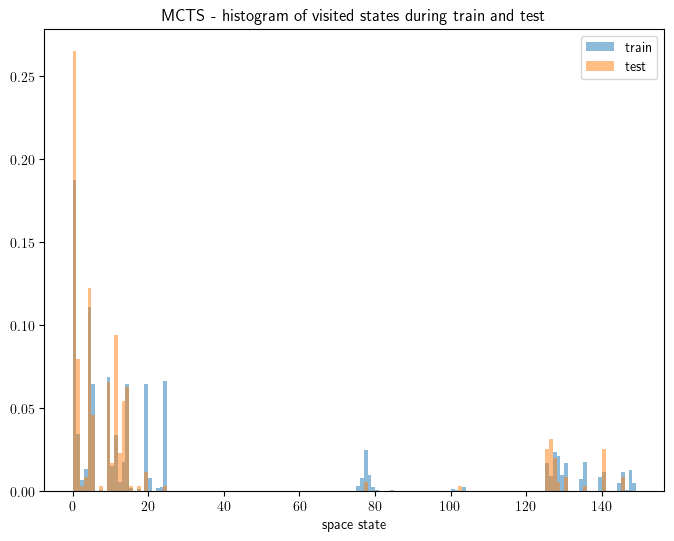

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(encode_visited_states_train, bins=range(total_number_of_states), density=True, alpha=0.5, label="train")
plt.title("MCTS - histogram of visited states during train and test")
plt.xlabel("space state")

plt.hist(encode_visited_states_test, bins=range(total_number_of_states), density=True, alpha=0.5, label="test")
plt.legend()

print("exploration in training:", round(np.unique(encode_visited_states_train).shape[0]/total_number_of_states, 2))
print("exploration in testing:", round(np.unique(encode_visited_states_test).shape[0]/total_number_of_states, 2))

ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

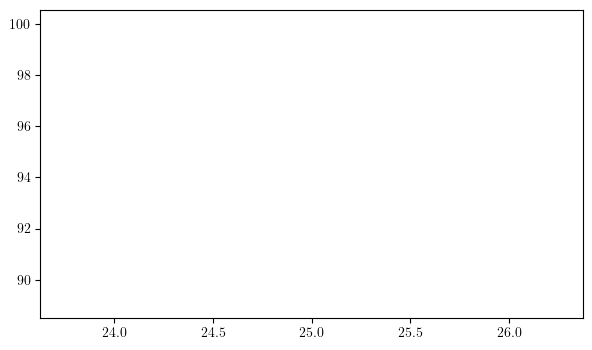

In [8]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS performance results on the custom gridworld, P="+str(p))
success_rates

Text(0.5, 1.0, 'training loss')

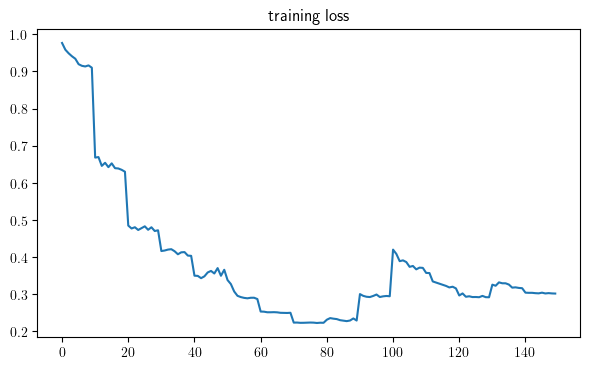

In [ ]:
interval = 400
plt.figure(figsize=(7,4))
plt.plot(train_history)
plt.title("training loss")
# plt.xticks(range(1,num_training_epochs*epochs,interval), range(0,num_training_epochs,interval//epochs));

In [ ]:
Q=csrl.q_learning(T=100,K=1000000)

KeyboardInterrupt: 

In [ ]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [ ]:
rewards_mean = []
rewards_std = []
n_runs = 100

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=(0,0), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 20 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


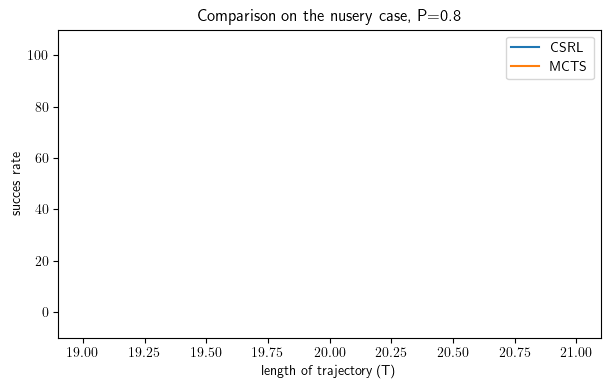

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the sequentil delivery case, P="+str(p))
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()